# Analysis of air pollution
by Alex Sun

link to data https://data.wprdc.org/dataset/toxic-release-inventory/resource/2750b8c8-246b-430f-b1e0-1aa96e00b013

This data comes from Allegheny county and measures air pollution.

Air pollution is bad for one's health. Simple as.

The following cell will take a while to run (~2 min); please be patient!

In [9]:
import fpsnippets
import pandas as pd

airPollutionCSV = pd.read_csv("airPollution.csv", index_col="_id")

query_mask = airPollutionCSV['CITY_NAME'] == "PITTSBURGH"

airPollutionPGH = airPollutionCSV[query_mask]

neighborhoodPollution = {}

for index, row in airPollutionPGH.iterrows():
    if isinstance(fpsnippets.zip_to_neighborhoods(row['ZIP_CODE']), list):
        if len(fpsnippets.zip_to_neighborhoods(row['ZIP_CODE'])) != 0:
            if not pd.isna(row['TOTAL_RELEASE']):
                adj_amount = row['TOTAL_RELEASE'] / len(fpsnippets.zip_to_neighborhoods(row['ZIP_CODE']))
            elif not pd.isna(row['REL_EST_AMT']):
                adj_amount = row['REL_EST_AMT'] / len(fpsnippets.zip_to_neighborhoods(row['ZIP_CODE']))
            else:
                adj_amount = 0

            for neighborhood in fpsnippets.zip_to_neighborhoods(row['ZIP_CODE']):
                if neighborhood in neighborhoodPollution:
                    neighborhoodPollution[neighborhood] += adj_amount
                else:
                    neighborhoodPollution[neighborhood] = adj_amount

nghpolSeries = pd.Series(neighborhoodPollution)
nghpolSorted = nghpolSeries.sort_values(ascending=True)
print(nghpolSorted.head(10))

# The total amount (in pounds) of the toxic chemical released to air during the calendar year (January 1 - December 31). 
# Release amounts may be reported as specific numbers or as ranges (RELEASE_RANGE_CODE).

West Oakland                  45.736667
Terrace Village               45.736667
Upper Hill                    45.736667
Crawford-Roberts              45.736667
Central Business District     45.736667
Bluff                         45.736667
North Oakland                 45.736667
Middle Hill                   45.736667
Bedford Dwellings             45.736667
Arlington Heights            372.614814
dtype: float64


# oh yeah
The data comes sorted by zip code, which isn't exactly what we're looking for...

To get a rough idea of pollution by neighborhood, we assume that every instance of pollution in a zip code is evenly distributed between the neighborhoods in that zip code.

The data themselves are measurements of lbs of air pollution released per year.

Let's take a look at the results.

<Axes: >

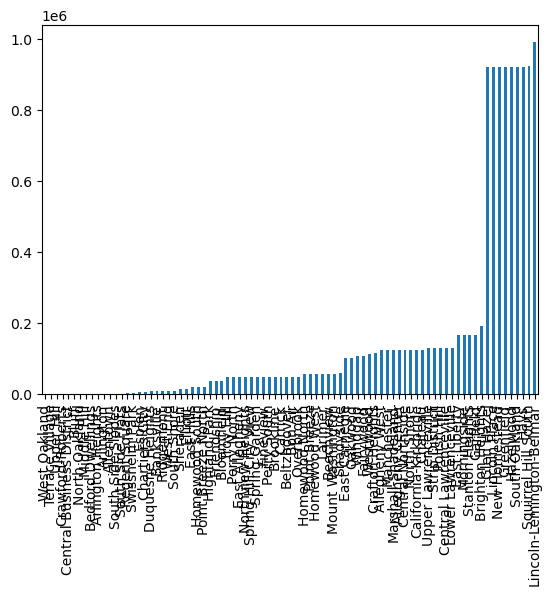

In [10]:
nghpolSorted.plot.bar()

# oh yikes
Looks like there are some ties...thanks to the zip codes each containing multiple neighborhoods. Well, without finer resolution data, this is the best we can do. Let's give them scores based on their pollution levels.

In [13]:
neighborhoodScore = {}
for key, value in nghpolSeries.items():
    neighborhoodScore[key] = (100 * (1 - (value / nghpolSorted.max())))
nghscoSeries = pd.Series(neighborhoodScore)
nghscoSorted = nghscoSeries.sort_values(ascending=False)
print(nghscoSorted.head(10))
len(nghscoSorted)

Crawford-Roberts             99.995380
North Oakland                99.995380
Bluff                        99.995380
Middle Hill                  99.995380
Terrace Village              99.995380
West Oakland                 99.995380
Upper Hill                   99.995380
Bedford Dwellings            99.995380
Central Business District    99.995380
Arlington                    99.962362
dtype: float64


84

# nice
Now they have scores from 0 to almost 100 that are based linearly upon their pollution level. Fantastic! We can now pronounce the winner: zip code 15219, encompassing most of the Hill District and inexplicably also Station Square. But it's a little strange that there are only 84 neighborhoods listed here when Pittsburgh has 90 neighborhoods...let's try to find the six neighborhoods so free of air pollution that they aren't present in the pollution data.

In [17]:
neighborhoodCSV = pd.read_csv("pgh_neighborhoods.csv", index_col="_id")

neighborhoods = []

cleanhoods = []

for index, row in neighborhoodCSV.iterrows():
    neighborhoods.append(row['hood'])

for neighborhood in neighborhoods:
    if neighborhood not in nghscoSorted.index:
        cleanhoods.append(neighborhood)

print(cleanhoods)

['Squirrel Hill North', 'Knoxville', 'Central Oakland', 'Mt. Oliver', 'St. Clair', 'Summer Hill']


# fresh air
And there they are. The six neighborhoods with the cleanest air. We can assign them scores of 100, as they have no pollution listed in the pollution dataset.

In [22]:
cleanscores = [100, 100, 100, 100, 100, 100]

cleanscoSeries = pd.Series(cleanscores, index=cleanhoods)

pghpolSco = pd.concat([cleanscoSeries, nghscoSorted])

print(pghpolSco)

Squirrel Hill North         100.000000
Knoxville                   100.000000
Central Oakland             100.000000
Mt. Oliver                  100.000000
St. Clair                   100.000000
                               ...    
Hazelwood                     7.066587
South Oakland                 7.061967
Hays                          7.029516
Squirrel Hill South           6.839303
Lincoln-Lemington-Belmar      0.000000
Length: 90, dtype: float64


# plot again
Let's plot it again.

<Axes: >

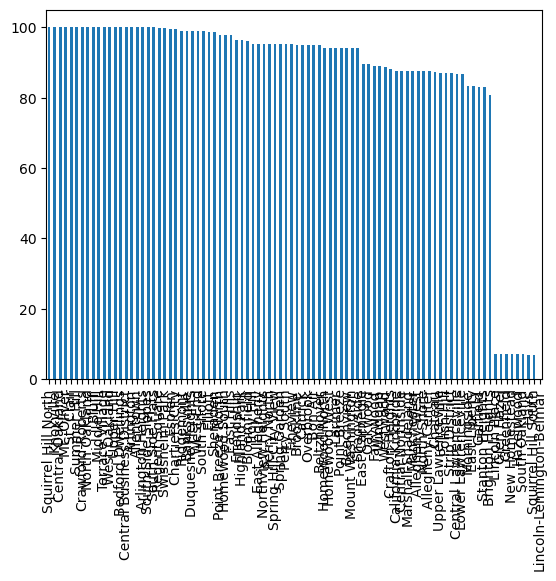

In [23]:
pghpolSco.plot.bar()

# end
Funny how Squirrel Hill and Oakland contain both ends of the spectrum within them...this is as far as I will go with my analysis, however. The six cleanest neighborhoods are above, and the rest are pretty close, with the exception of a few extremely dirty neighborhoods.